# German Traffic Sign Recognition Benchmarkers
- GTSRB 데이터란? : http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset
- Resnet CNN을 이용하여 GTSRB data를 classification 하고자 한다.
- metrics : accuracy를 사용할 예정
- train 데이터 수 : 31368
- valid 데이터 수 : 7841
- 총 class 수 : 43



## Data download

In [ ]:
# GTSRB trainingset download
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip

--2020-12-02 00:34:44--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276294756 (263M) [application/zip]
Saving to: ‘GTSRB_Final_Training_Images.zip’

GTSRB_Final_Trainin 100%[===================>] 263.50M  18.2MB/s    in 15s     

2020-12-02 00:35:01 (17.2 MB/s) - ‘GTSRB_Final_Training_Images.zip’ saved [276294756/276294756]



In [ ]:
!unzip GTSRB_Final_Training_Images.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: GTSRB/Final_Training/Images/00035/00000_00019.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00020.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00021.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00022.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00023.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00024.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00025.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00026.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00027.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00028.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00029.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00001_00000.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00001_00001.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00001_00002.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00001_0

In [ ]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

## Data generator and split train, valid set
- valid ratio : 0.2
- rescale : 1./255
- color_mode : gray scale
- batch size: 64

In [ ]:
train_data_gen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    shear_range=.2,
    zoom_range = .1,
    validation_split=.2,
)

In [ ]:
base_dir = './GTSRB/Final_Training/Images'
train_generator = train_data_gen.flow_from_directory(
    base_dir,
    target_size=(32, 32),
    batch_size=64,
    color_mode = 'rgb',
    subset='training'
)

Found 31368 images belonging to 43 classes.


In [ ]:
test_generator = train_data_gen.flow_from_directory(
    base_dir,
    target_size=(32,32),
    batch_size=64,
    color_mode = 'rgb',
    subset='validation'
)

Found 7841 images belonging to 43 classes.


## ResidualUnit layer for ResNet model
- 설명 : https://curaai00.tistory.com/6

In [ ]:
# earlystopping과 model callback을 위해서 아래와 같이 get_config 적용

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.conv1 = keras.layers.Conv2D(filters, 3, strides=strides, padding='same', use_bias=False)
        self.bn = keras.layers.BatchNormalization()
        self.conv2 = keras.layers.Conv2D(filters, 3, strides=1, padding='same', use_bias=False)
        self.bn2 = keras.layers.BatchNormalization()
        self.main_layers = [self.conv1, self.bn, self.conv2, self.bn2]
        # self.main_layers = [
        #     keras.layers.Conv2D(filters, 3, strides=strides, padding='same', use_bias=False),
        #     keras.layers.BatchNormalization(),
        #     self.activation,
        #     keras.layers.Conv2D(filters, 3, strides=1, padding='same', use_bias=False),
        #     keras.layers.BatchNormalization(),
        # ]
        self.strides = strides
        self.skip_layers = []
        if strides > 1:
            self.skip_layer_conv = keras.layers.Conv2D(filters, 1, strides=strides, padding='same', use_bias=False)
            self.skip_layer_bn = keras.layers.BatchNormalization()
            self.skip_layers = [self.skip_layer_conv, self.skip_layer_bn]
            # self.skip_layers = [
            #     keras.layers.Conv2D(filters, 1, strides=strides, padding='same', use_bias=False),
            #     keras.layers.BatchNormalization(),
            # ]
            
    def get_config(self):
        config = super().get_config().copy()
        dict_config = {
            'activation' : self.activation,
            'conv1': self.conv1,
            'bn' : self.bn,
            'conv2' : self.conv2,
            'bn2' : self.bn2,
        }
        if self.strides > 1:
          dict_config['skip_layer_conv'] = self.skip_layer_conv
          dict_config['skip_layer_bn'] = self.skip_layer_bn

        config.update(dict_config)
        return config
            
    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z= layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z+skip_Z)

In [ ]:
# resnet model
def make_model():
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(64, 7, strides=2, input_shape=[32,32,3], padding='same', use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'))
    prev_filters = 64
    for filters in [64]*3 + [128]*4 + [256]*6 + [512]*3:
        strides = 1 if filters == prev_filters else 2
        model.add(ResidualUnit(filters, strides=strides))
        prev_filters = filters
    model.add(keras.layers.GlobalAvgPool2D())
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(43, activation='softmax'))
    return model

In [ ]:
resnet_model = make_model()

## Model shape

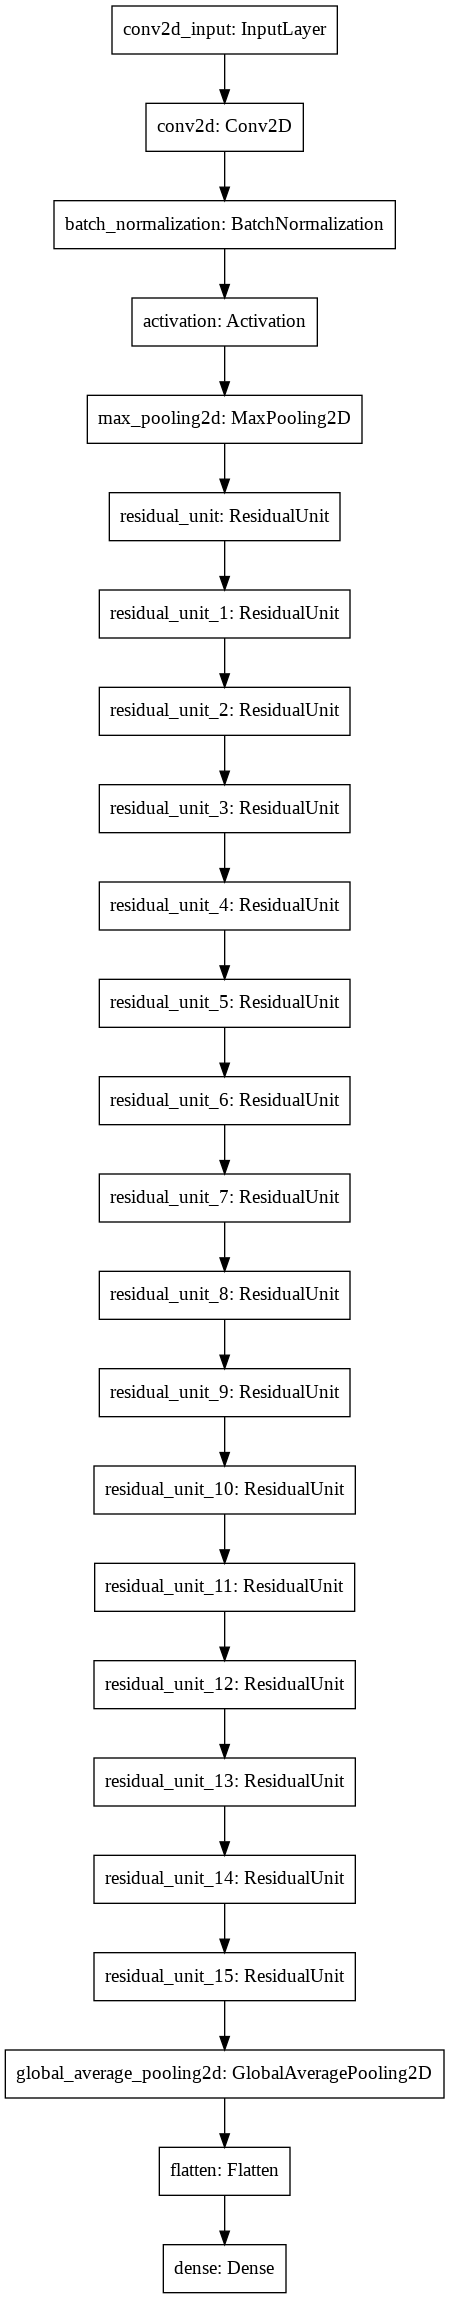

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(resnet_model)

## Training

In [ ]:
# GPU를 사용
with tf.device('/device:GPU:0'):
  resnet_model = make_model()
  resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  early_stopping = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor = 'val_accuracy')
  checkpoint = keras.callbacks.ModelCheckpoint('./resnet_model.h5', monitor='val_accuracy', save_best_only=True)
  history = resnet_model.fit(train_generator, epochs=100, callbacks=[early_stopping, checkpoint], validation_data=test_generator)


Epoch 1/100
491/491 [==============================] - 34s 70ms/step - loss: 1.2454 - accuracy: 0.6369 - val_loss: 0.9025 - val_accuracy: 0.7338
Epoch 2/100
491/491 [==============================] - 33s 67ms/step - loss: 0.2970 - accuracy: 0.9071 - val_loss: 0.8793 - val_accuracy: 0.7772
Epoch 3/100
491/491 [==============================] - 32s 66ms/step - loss: 0.1524 - accuracy: 0.9510 - val_loss: 0.5154 - val_accuracy: 0.8690
Epoch 4/100
491/491 [==============================] - 31s 64ms/step - loss: 0.1091 - accuracy: 0.9659 - val_loss: 0.5584 - val_accuracy: 0.8572
Epoch 5/100
491/491 [==============================] - 31s 62ms/step - loss: 0.0795 - accuracy: 0.9750 - val_loss: 0.6423 - val_accuracy: 0.8513
Epoch 6/100
491/491 [==============================] - 32s 65ms/step - loss: 0.0967 - accuracy: 0.9711 - val_loss: 0.6258 - val_accuracy: 0.8725
Epoch 7/100
491/491 [==============================] - 30s 62ms/step - loss: 0.0678 - accuracy: 0.9790 - val_loss: 0.6056 - val_ac

## Test data download
- GTSRB_Final_Test_Images : 이미지 파일
- GTSRB_Final_Test_GT : Label 값이 있는 image_name;csv 파일

In [ ]:
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip

--2020-12-02 01:03:25--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88978620 (85M) [application/zip]
Saving to: ‘GTSRB_Final_Test_Images.zip’

GTSRB_Final_Test_Im 100%[===================>]  84.86M  19.6MB/s    in 5.4s    

2020-12-02 01:03:32 (15.6 MB/s) - ‘GTSRB_Final_Test_Images.zip’ saved [88978620/88978620]



In [ ]:
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip

--2020-12-02 01:03:32--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99620 (97K) [application/zip]
Saving to: ‘GTSRB_Final_Test_GT.zip’

GTSRB_Final_Test_GT 100%[===================>]  97.29K   208KB/s    in 0.5s    

2020-12-02 01:03:33 (208 KB/s) - ‘GTSRB_Final_Test_GT.zip’ saved [99620/99620]



In [ ]:
!unzip GTSRB_Final_Test_Images.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: GTSRB/Final_Test/Images/07632.ppm  
  inflating: GTSRB/Final_Test/Images/07633.ppm  
  inflating: GTSRB/Final_Test/Images/07634.ppm  
  inflating: GTSRB/Final_Test/Images/07635.ppm  
  inflating: GTSRB/Final_Test/Images/07636.ppm  
  inflating: GTSRB/Final_Test/Images/07637.ppm  
  inflating: GTSRB/Final_Test/Images/07638.ppm  
  inflating: GTSRB/Final_Test/Images/07639.ppm  
  inflating: GTSRB/Final_Test/Images/07640.ppm  
  inflating: GTSRB/Final_Test/Images/07641.ppm  
  inflating: GTSRB/Final_Test/Images/07642.ppm  
  inflating: GTSRB/Final_Test/Images/07643.ppm  
  inflating: GTSRB/Final_Test/Images/07644.ppm  
  inflating: GTSRB/Final_Test/Images/07645.ppm  
  inflating: GTSRB/Final_Test/Images/07646.ppm  
  inflating: GTSRB/Final_Test/Images/07647.ppm  
  inflating: GTSRB/Final_Test/Images/07648.ppm  
  inflating: GTSRB/Final_Test/Images/07649.ppm  
  inflating: GTSRB/Final_Test/Images/07650.ppm  
  inflating: GTSRB/Final_Test/Ima

In [ ]:
!unzip GTSRB_Final_Test_GT.zip

Archive:  GTSRB_Final_Test_GT.zip
  inflating: GT-final_test.csv       


In [ ]:
ls

GT-final_test.csv        GTSRB_Final_Test_Images.zip      resnet_model.h5
GTSRB/                   GTSRB_Final_Training_Images.zip  sample_data/
GTSRB_Final_Test_GT.zip  model.png


In [ ]:
import pandas as pd
data = pd.read_csv('GT-final_test.csv', sep=';')

In [ ]:
data

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
0,00000.ppm,53,54,6,5,48,49,16
1,00001.ppm,42,45,5,5,36,40,1
2,00002.ppm,48,52,6,6,43,47,38
3,00003.ppm,27,29,5,5,22,24,33
4,00004.ppm,60,57,5,5,55,52,11
...,...,...,...,...,...,...,...,...
12625,12625.ppm,42,41,5,6,37,36,12
12626,12626.ppm,50,51,6,5,45,46,33
12627,12627.ppm,29,29,6,6,24,24,6
12628,12628.ppm,48,49,5,6,43,44,7


In [ ]:
with open('GTSRB/Readme-Images-Final-test.txt', 'r', encoding='iso-8859-1') as f:
  text = f.read()

In [ ]:
print(text)

**********************************************
The German Traffic Sign Recognition Benchmark
**********************************************

This archive contains the test set of the 
"German Traffic Sign Recognition Benchmark". 

This is the official test set that is used during the final 
competition session at IJCNN 2011. After the conference, 
it will be published on our website. 

If you want to publish results based on GTSRB, 
this data set is to be used for final testing purposes
only. Please use the GTSRB (final) training set for training
(It is the joint dataset of the online competition's 
training and test set).


**********************************************
Archive content
**********************************************
This archive contains the following structure:

There is one directory that contains all test images (12,630 images) 
and one text file with annotations (GT-final_test.test.csv)


**********************************************
Image format and naming
******

## Load test image(ppm) dataset

In [ ]:
import glob
from skimage.color import rgb2gray
from skimage.transform import resize
from collections import namedtuple
import numpy as np

In [ ]:
import os
Dataset = namedtuple('Dataset', ['X','path'])
RESIZED_IMAGE = (32, 32, 3)
def to_tf_format(imgs):
    return np.stack([img for img in imgs], axis=0).astype(np.float32)

def read_dataset_ppm(rootpath, resize_to):
  images = []
  path = []
  
  full_path = rootpath + os.sep
  for img_name in glob.glob(full_path + "*.ppm"):
    
    img = plt.imread(img_name).astype(np.float32)
    img = img / 255.0

    if resize_to:
      img = resize(img, resize_to, mode='reflect')

    path.append(os.path.basename(img_name))
    images.append(img.astype(np.float32))

  return Dataset(X = to_tf_format(images).astype(np.float32), path = path)

dataset = read_dataset_ppm('GTSRB/Final_Test/Images', RESIZED_IMAGE)

In [ ]:
dataset.X.shape

(12630, 32, 32, 3)

03244.ppm


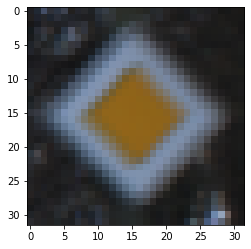

In [ ]:
# sample image
plt.imshow(dataset.X[0, :, :, :].reshape(RESIZED_IMAGE))
print(dataset.path[0])

## Predict

In [ ]:
y_pred = resnet_model.predict(dataset.X).argmax(axis=1)

In [ ]:
result_predict_test = [[img_name , model_predict] for img_name, model_predict in zip(dataset.path, y_pred)]

In [ ]:
import pandas as pd
result_predict_test = pd.DataFrame(result_predict_test, columns=['path', 'y_pred'])

In [ ]:
result_predict_test.head()

,path,y_pred
0,03244.ppm,12
1,09737.ppm,39
2,03482.ppm,17
3,06294.ppm,11
4,03191.ppm,12


In [ ]:
for_compare_result = pd.merge(result_predict_test, data[['Filename','ClassId']], left_on='path', right_on='Filename')

## Result
- Metrics : Accuracy(0.937)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(for_compare_result['y_pred'], for_compare_result['ClassId'])

0.9395882818685669

In [ ]:
result_predict_test.to_csv('gtsrb_final_test_image_rgb_predict_result.csv', index=False)

In [ ]:
from google.colab import files
files.download('gtsrb_final_test_image_rgb_predict_result.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('./resnet_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>